In [3]:
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

# from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam


In [4]:
# Path where our data is located
base_path = "C:/Users/Dell/Downloads/GSASLdatasets/train/"

# Dictionary to save our 29 classes
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "J",
                10: "K",
                11: "L",
                12: "M",
                13: "N",
                14: "O",
                15: "P",
                16: "Q",
                17: "R",
                18: "S",
                19: "T",
                20: "U",
                21: "V",
                22: "W",
                23: "X",
                24: "Y",
                25: "Z",
                26: "del",
                27: "nothing",
                28: "space",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df


filename  category
0          bw_K948.jpg        10
1         bw_P1417.jpg        15
2      bw_space994.jpg        28
3         bw_V1880.jpg        21
4         bw_C1022.jpg         2
...                ...       ...
69595        bw_E7.jpg         4
69596     bw_B1872.jpg         1
69597       bw_Q82.jpg        16
69598       bw_E33.jpg         4
69599      bw_O263.jpg        14

[69600 rows x 2 columns]

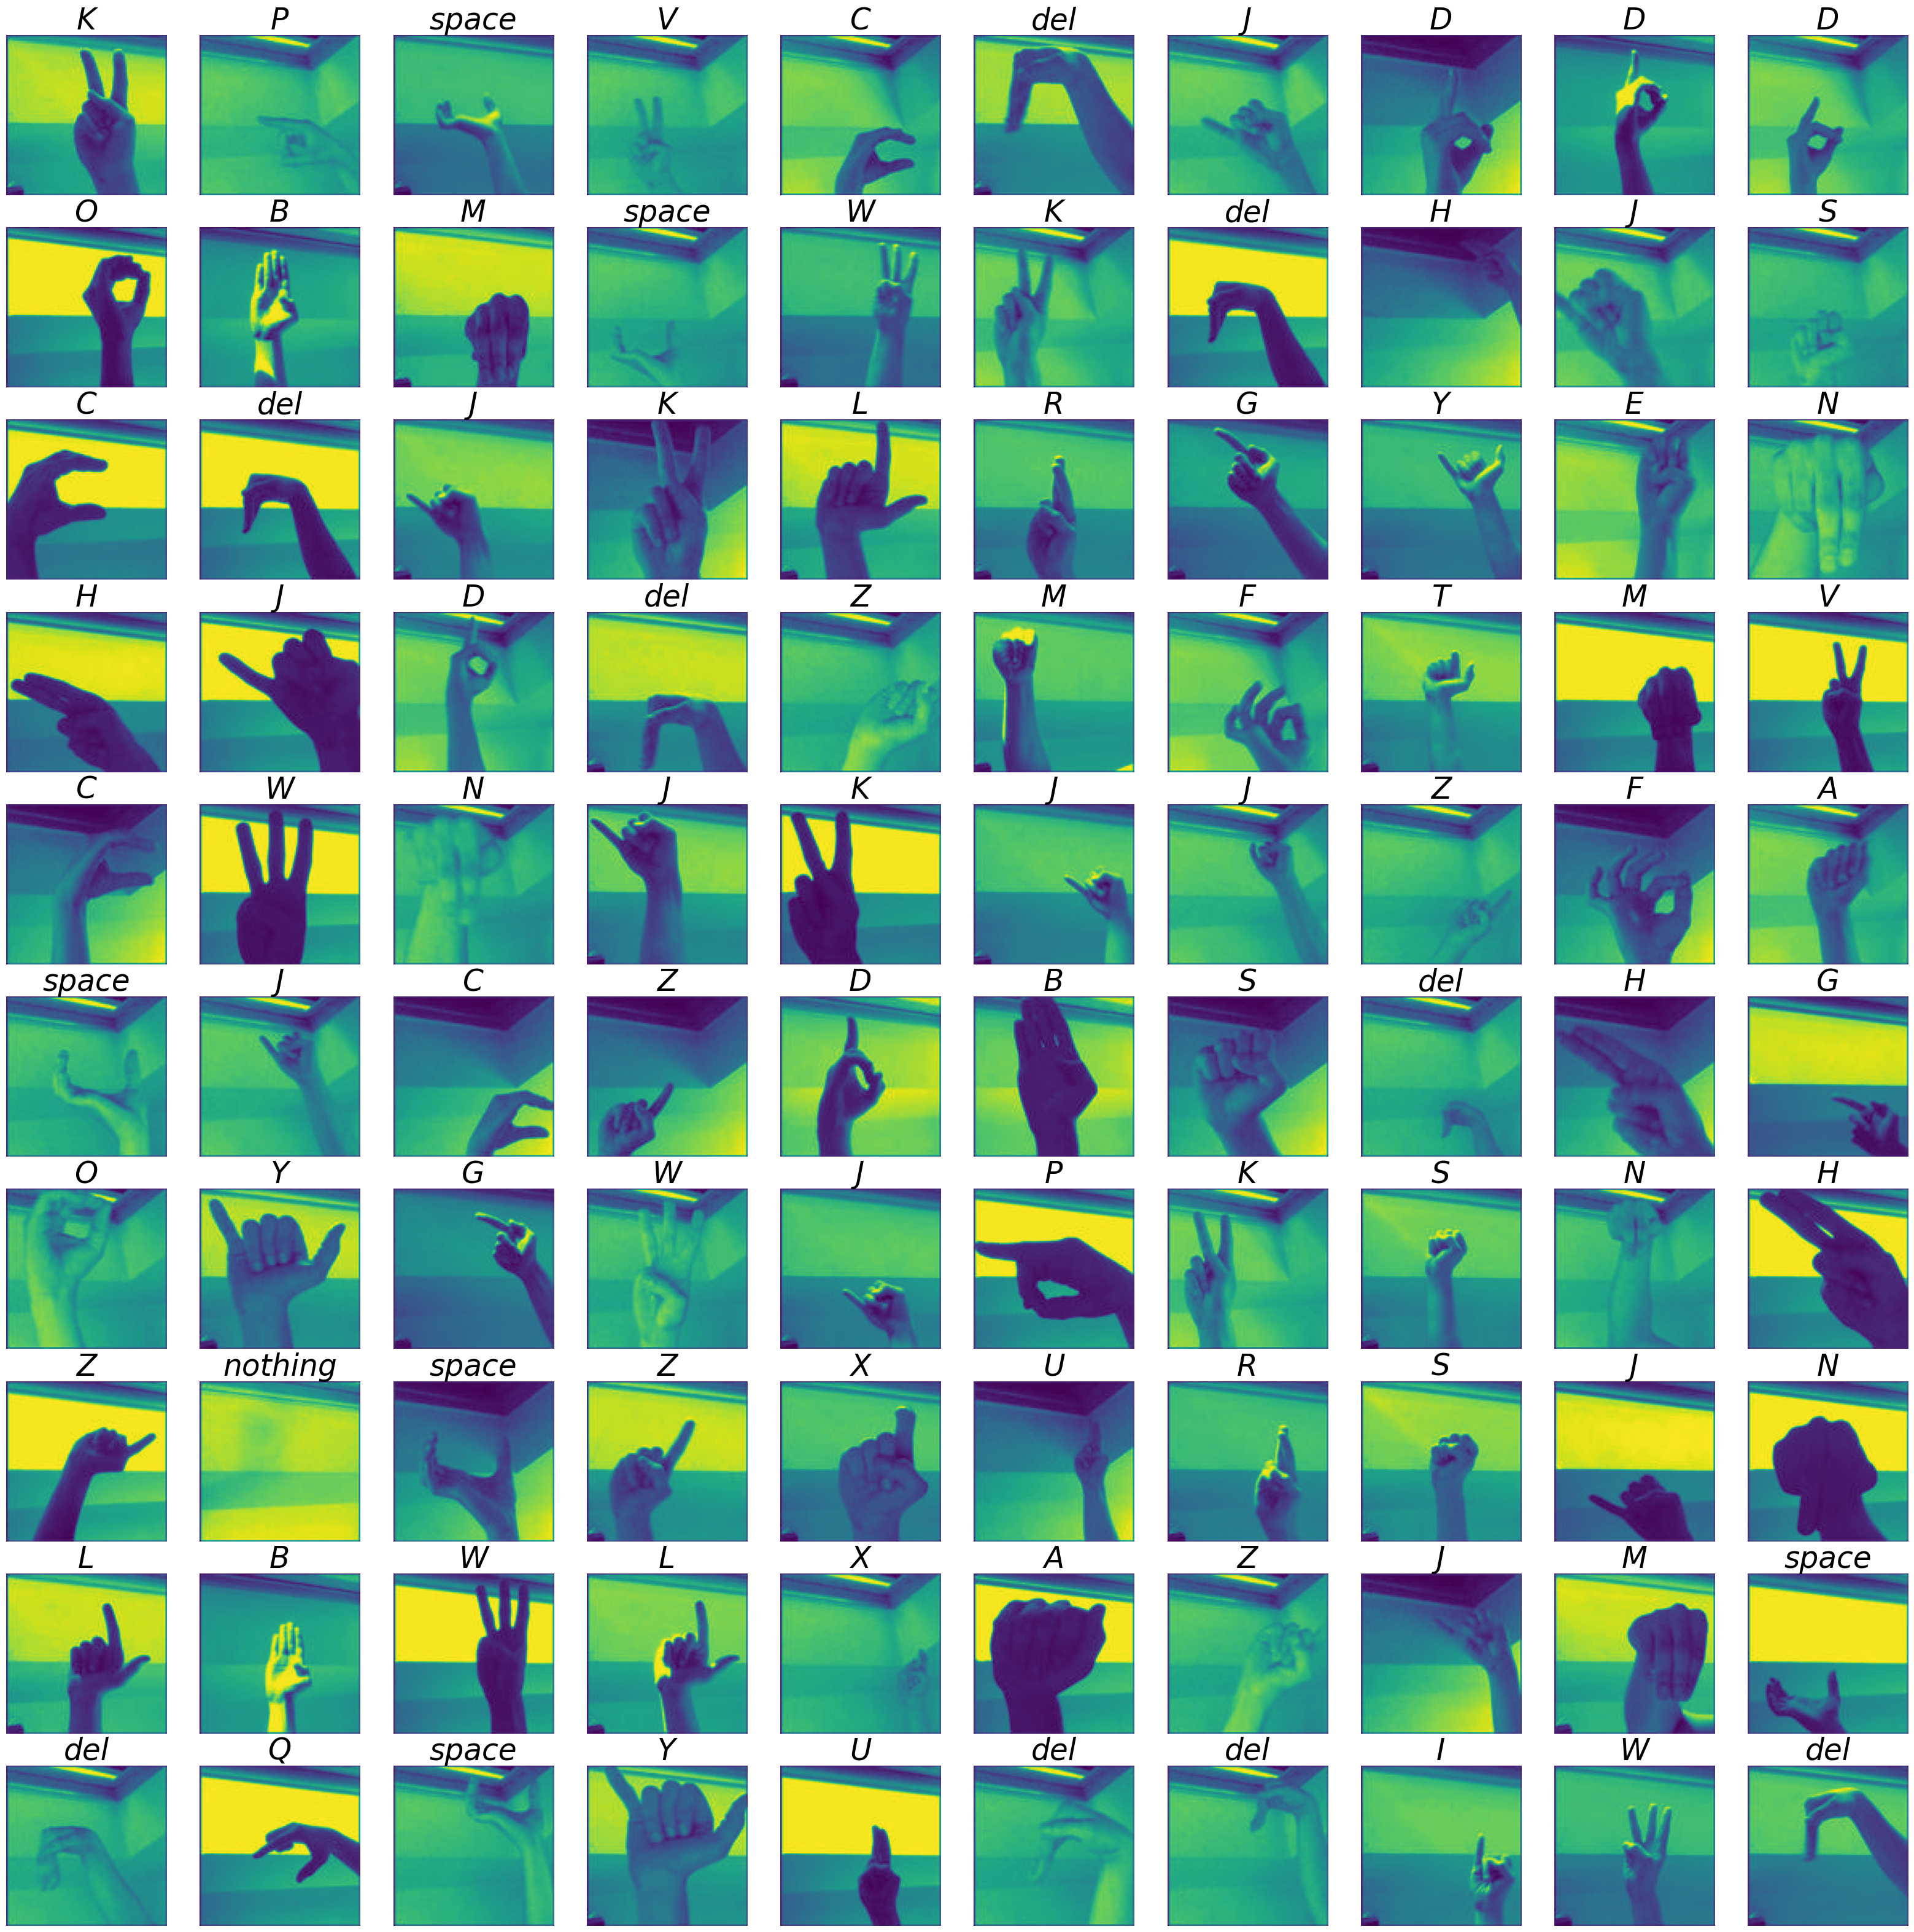

In [6]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = ""
    path = os.path.join(base_path, categories[df.category[i]], df.filename[i])
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

In [7]:
datagen = ImageDataGenerator(rescale=1.0 / 255,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [8]:
train_path = 'C:/Users/Dell/Downloads/GSASLdatasets/train/'
val_path = 'C:/Users/Dell/Downloads/GSASLdatasets/val/'
test_path = 'C:/Users/Dell/Downloads/GSASLdatasets/test/'

# Define hyperparameters and parameters
batch_size = 32
image_size = 100
img_channel = 1
num_classes = 29
learning_rate = 0.001

In [9]:
train_data = datagen.flow_from_directory(directory=train_path,
                                         target_size=(image_size, image_size),
                                         batch_size=batch_size,
                                          color_mode='grayscale',
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory=val_path,
                                       target_size=(image_size, image_size),
                                       batch_size=batch_size,
                                        color_mode='grayscale',
                                       class_mode='categorical')

test_data = datagen.flow_from_directory(directory=test_path,
                                        target_size=(image_size, image_size),
                                        batch_size=batch_size,
                                         color_mode='grayscale',
                                        class_mode='categorical',
                                        shuffle=False)

Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [10]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=(image_size, image_size, img_channel)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                        

In [11]:
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, restore_best_weights=True, verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.6, verbose=1)


In [13]:
checkpoint_path = "checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         verbose=1)

In [14]:
history = model.fit(train_data,
          epochs=10,
          validation_data=val_data,
          callbacks=[checkpoint_callback])

Epoch 1/10


: 

In [2]:
model.load_weights(checkpoint_path)
history_2 = model.fit(train_data,
                      initial_epoch=7,  # Start from epoch 10
                      epochs=30,         # Train for additional 5 epochs
                      validation_data=val_data,
                      callbacks=[checkpoint_callback])

NameError: name 'model' is not defined

In [ ]:
combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_2.history[key]


In [ ]:
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [32]:
model.save('GSASLmodel.h5')

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
from keras.models import load_model

# Load the saved model
model = load_model('E:/django/TheSilentVoice-signlanguagerecognition/signlanguage/model/20GSASLmodel.h5')


In [11]:
test_results = model.evaluate(test_data)

272/272 [==============================] - 218s 797ms/step - loss: 0.4881 - accuracy: 0.9475


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions for the test data
y_pred_probs = model.predict(test_data)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test data generator
y_true = test_data.classes

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes)

# Print the classification report
print("Classification Report:\n", class_report)

# Generate a confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_mat)


272/272 [==============================] - 173s 635ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.99      0.97      0.98       300
           2       0.99      0.99      0.99       300
           3       0.97      0.99      0.98       300
           4       0.99      0.98      0.98       300
           5       1.00      0.99      0.99       300
           6       0.99      0.98      0.98       300
           7       0.97      1.00      0.98       300
           8       0.86      0.99      0.92       300
           9       1.00      0.99      0.99       300
          10       1.00      0.62      0.77       300
          11       0.93      0.99      0.96       300
          12       0.99      0.96      0.98       300
          13       0.97      0.99      0.98       300
          14       1.00      0.99      0.99       300
          15       0.63      1.00      0.78       30

272/272 [==============================] - 169s 622ms/step


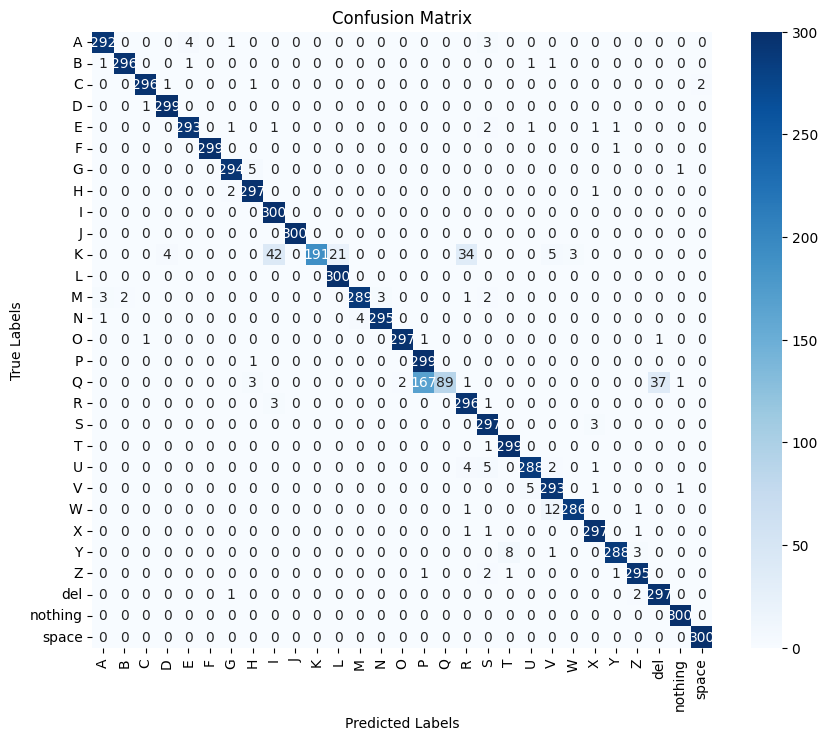

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions for the test data
y_pred_probs = model.predict(test_data)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test data generator
y_true = test_data.classes

# Generate a confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


272/272 [==============================] - 169s 621ms/step - loss: 0.4670 - accuracy: 0.9506


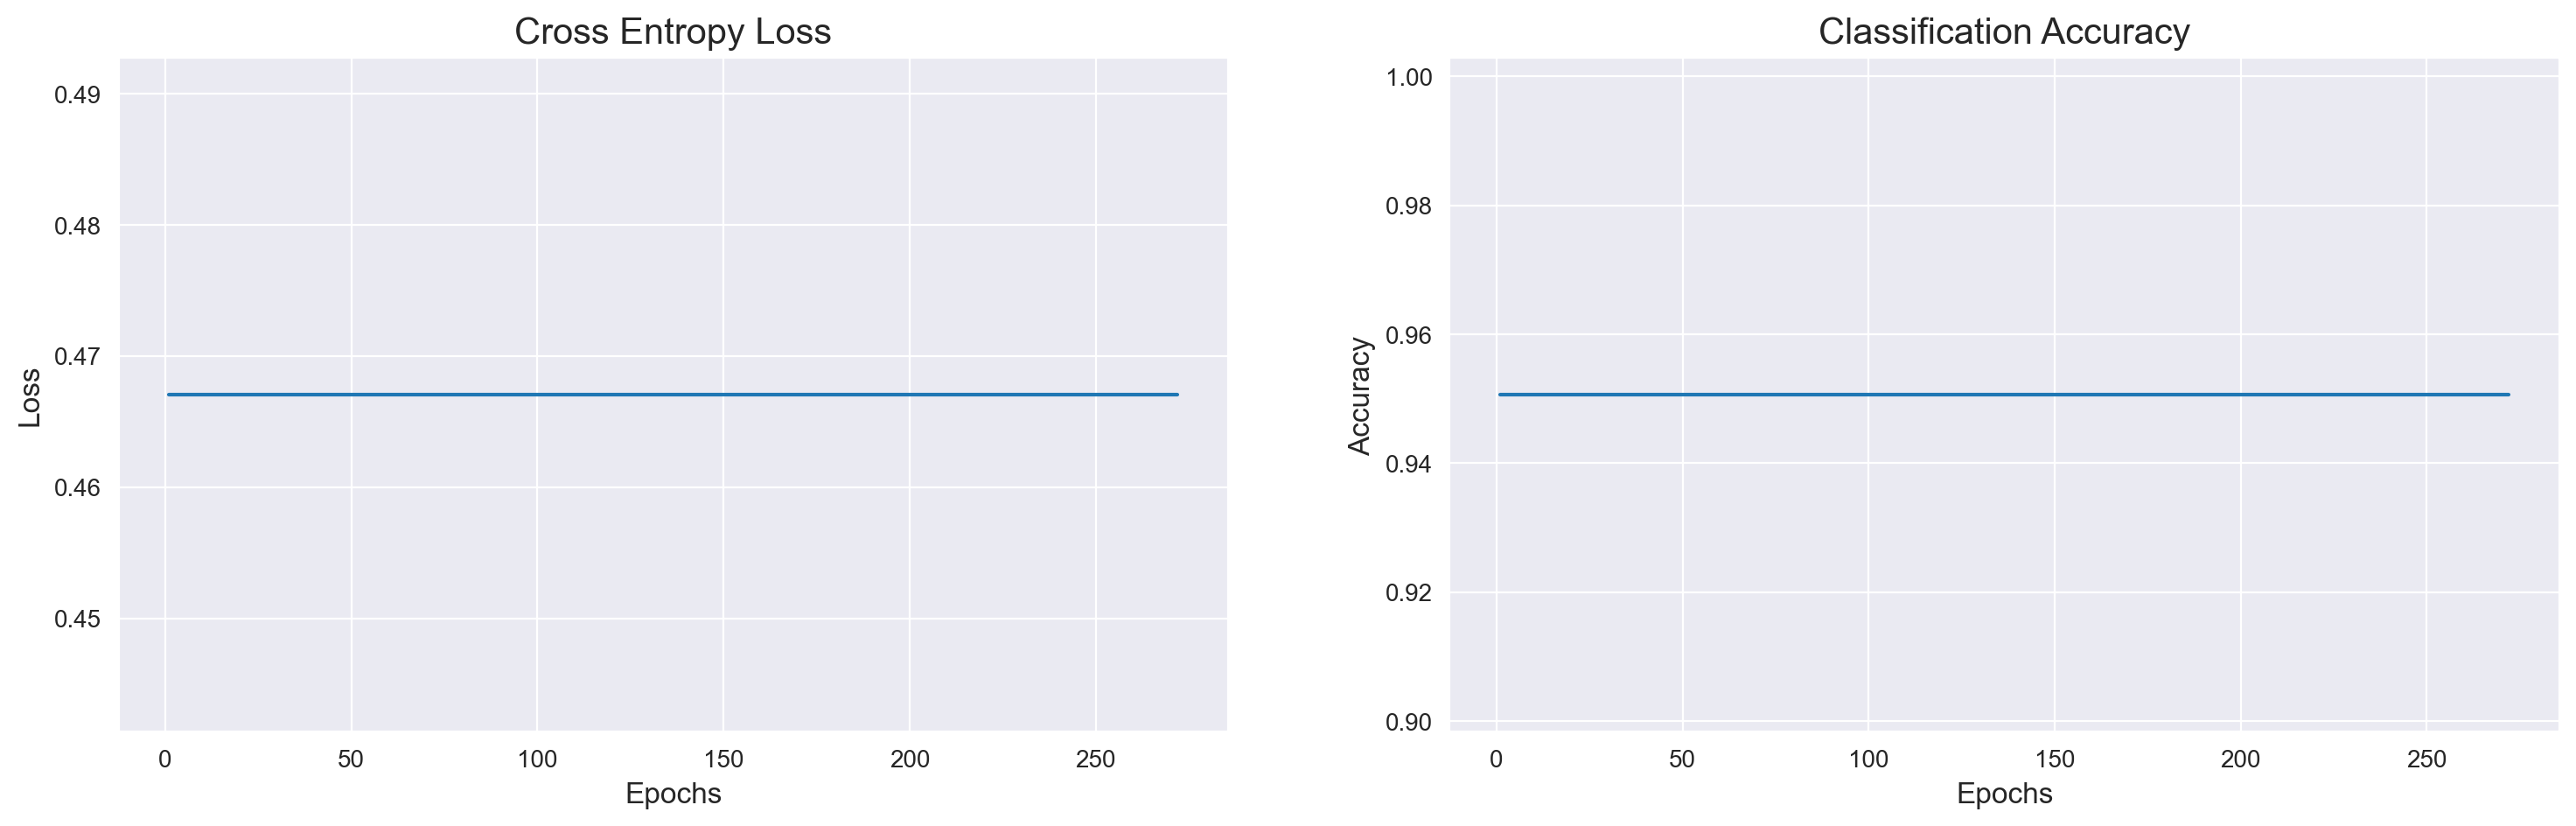

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a test data generator (val_data) for validation
# Replace this with your actual validation data generator

# Load the saved model


# Evaluate the model on the validation data to get loss and accuracy
val_loss, val_accuracy = model.evaluate(val_data)

# Number of training steps per epoch
# This may vary based on your data generator and batch size
# If you know the number of samples in your validation set, you can use:
# steps_per_epoch = total_samples / batch_size
# where total_samples is len(val_data) * batch_size
steps_per_epoch = len(val_data)

# Number of epochs
num_epochs = len(val_data)

# Create a range of epochs
epochs = np.arange(1, num_epochs + 1)

# Create arrays for loss and accuracy with the same values
loss = np.full(num_epochs, val_loss)
accuracy = np.full(num_epochs, val_accuracy)

# Plot the Cross Entropy Loss
plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(epochs, loss, label='Validation Loss')

# Plot the Classification Accuracy
plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(epochs, accuracy, label='Validation Accuracy')

plt.show()
